In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
from torch import nn, optim
import scipy.stats as stats
import matplotlib.pyplot as plt
from google.colab import drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Mount Google Drive
drive.mount('/content/drive/')

# Load CSV
csv_path = '/content/drive/My Drive/dataset/details.csv'
df = pd.read_csv(csv_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
# Split into training, validation, and test sets
train_df = df[df['set'] == 'training']
val_df = df[df['set'] == 'validation']
test_df = df[df['set'] == 'test']

In [9]:
# Transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for ResNet
])

In [10]:
# Dataset class
class MOSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        image = Image.open(f"/content/drive/My Drive/dataset/images/{img_path}").convert('RGB')
        mos = float(self.dataframe.iloc[idx]['MOS'])

        if self.transform:
            image = self.transform(image)
        mos = torch.tensor(mos, dtype=torch.float32)
        return image, mos

In [11]:
# Create datasets and dataloaders
train_dataset = MOSDataset(train_df, transform)
val_dataset = MOSDataset(val_df, transform)
test_dataset = MOSDataset(test_df, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
# Load the pre-trained ResNet model and modify the final layer
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)

# Setup device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


In [13]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [14]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
srocc_vals = []
plcc_vals = []

In [ ]:
# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    pred = []
    target_arr = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
            pred.extend(outputs.squeeze().cpu().numpy())
            target_arr.extend(targets.cpu().numpy())

    # Calculate average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Compute SROCC and PLCC
    srocc, _ = stats.spearmanr(pred, target_arr)
    plcc, _ = stats.pearsonr(pred, target_arr)
    srocc_vals.append(srocc)
    plcc_vals.append(plcc)

    print(f"Validation Loss: {val_loss:.4f}, SROCC: {srocc:.4f}, PLCC: {plcc:.4f}")


In [28]:
torch.save(model.state_dict(), 'mos_resnet_model_80.pth')

In [ ]:
# Load the trained model for testing
model.load_state_dict(torch.load('mos_resnet_model_80.pth'))


In [ ]:
# Testing step
model.eval()
test_loss = 0.0
target_arr = []
pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        pred.extend(outputs.squeeze().cpu().numpy())
        target_arr.extend(targets.cpu().numpy())
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

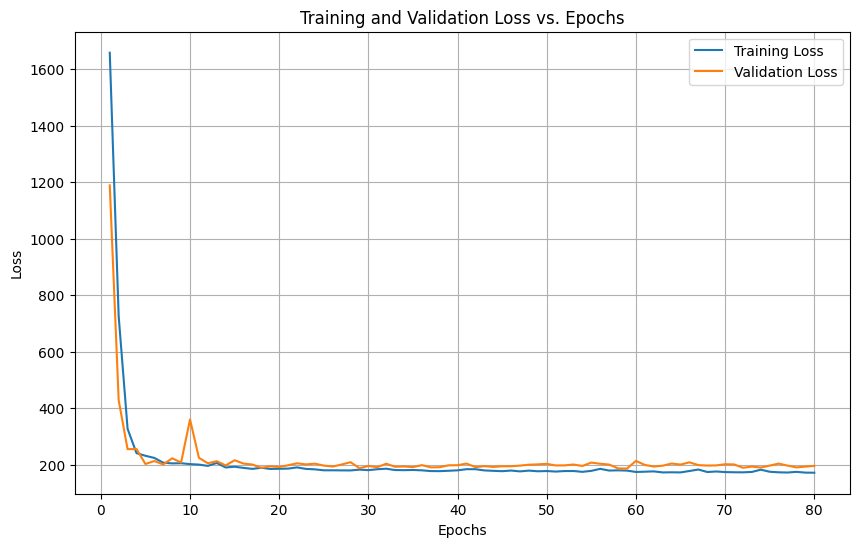

In [31]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

MOS: 51.48


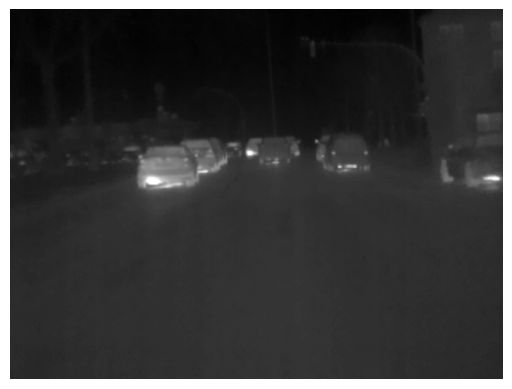

fog341.png


In [33]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

# Ensure the model is on the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
model = model.to(device)

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for ResNet
])

# Load and preprocess the image
inp = Image.open("/content/drive/My Drive/dataset/images/fog341.png")
inp = inp.convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
inp = transform(inp)
inp = inp.unsqueeze(0).to(device)  # Move the input to the same device as the model

# Perform inference
with torch.no_grad():
    outputs = model(inp)[0][0] + 20

# Display the original image in grayscale
inp = Image.open("/content/drive/My Drive/dataset/images/fog341.png")

plt.imshow(inp, cmap='gray')
plt.axis('off')  # Turn off axis lines and labels

print(f"MOS: {outputs:.2f}")
plt.show()
print(os.path.basename(inp.filename))

MOS: 20.98


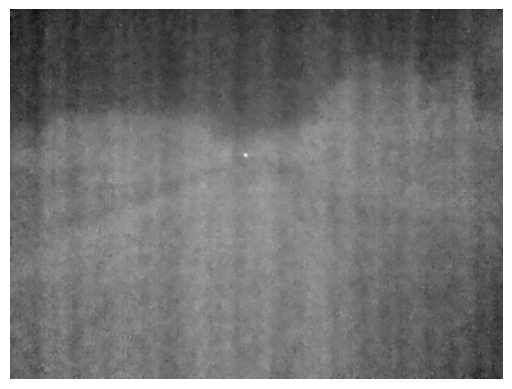

heavyrain28.png


In [44]:
#this one has converted picture to rgb
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import os

# Ensure the model is on the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
model = model.to(device)

# Image transformation pipeline (consistent with training/validation/testing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for ResNet
])

# Load and preprocess the image
image_path = "/content/drive/My Drive/dataset/images/heavyrain28.png"
inp = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode
processed_image = transform(inp).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Perform inference
with torch.no_grad():
    outputs = model(processed_image).squeeze().item()  # Get the predicted MOS

# Display the original image in grayscale
inp = Image.open("/content/drive/My Drive/dataset/images/heavyrain28.png")

plt.imshow(inp, cmap='gray')
plt.axis('off')  # Turn off axis lines and labels

print(f"MOS: {outputs:.2f}")
plt.show()
print(os.path.basename(inp.filename))

In [57]:
# prompt: give code to find mos for all testing images having mos ranges from 1- 25, give the list of them in column, with their name and predicted scores from 0 -25

import pandas as pd

# Assuming 'test_df' and 'pred' are defined from the previous code
# Create a DataFrame for the results
results_df = pd.DataFrame({'Image Name': test_df['image'], 'Predicted MOS': pred})

# Filter for MOS values between 1 and 25 (inclusive)
results_df = results_df[results_df['Predicted MOS'].between(1, 25)]

# Display the results
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('test_image_mos_predictions.csv', index=False)

            Image Name  Predicted MOS
915   heavyrain136.png      21.472113
938    heavyrain28.png      20.984991
1926    drizzle472.png      23.630520
1933    drizzle480.png      24.644482
1945    drizzle280.png      23.904123
1947     drizzle48.png      24.291592
3628       rain129.png      21.504681
3736       rain237.png      24.346094
3758       rain259.png      22.251780
3771       rain272.png      21.716873
3809       rain310.png      22.381546
3811       rain312.png      19.769075
5300      frost801.png      22.889761
5302      frost803.png      23.595190
5304      frost805.png      22.911589
5307      frost808.png      23.032379
5309      frost810.png      23.181253
5311      frost812.png      24.005217
5323      frost824.png      23.132463
5328      frost829.png      23.036268
5330      frost831.png      22.707241
5336      frost837.png      23.257505
5344      frost845.png      22.138277
5347      frost848.png      21.819876
5348      frost849.png      21.495741
5349      fr

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Assuming 'test_df', 'pred', and 'target_arr' are defined from the previous code
# Create a DataFrame for the results
results_df = pd.DataFrame({'Image Name': test_df['image'], 'Predicted MOS': pred, 'Ground Truth MOS': target_arr})

# Filter for MOS values between 1 and 25 (inclusive)
results_df = results_df[results_df['Predicted MOS'].between(1, 25)]


# Calculate SROCC
srocc, _ = stats.spearmanr(results_df['Ground Truth MOS'], results_df['Predicted MOS'])

"""
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Ground Truth MOS'], results_df['Predicted MOS'], alpha=0.7)
plt.xlabel('Ground Truth MOS')
plt.ylabel('Predicted MOS')
plt.title(f'Ground Truth vs. Predicted MOS (SROCC: {srocc:.2f})')

# Set x and y limits to the same range for a fair comparison
min_val = min(results_df['Ground Truth MOS'].min(), results_df['Predicted MOS'].min())
max_val = max(results_df['Ground Truth MOS'].max(), results_df['Predicted MOS'].max())
plot_range = (min_val, max_val)
plt.xlim(plot_range)
plt.ylim(plot_range)

# Ensure the aspect ratio is equal for a clearer comparison
plt.gca().set_aspect('equal', adjustable='box')

# Add a diagonal line for reference
plt.plot(plot_range, plot_range, color='red', linestyle='--')

plt.grid(True)
plt.show()
"""
# Display the results
print(results_df)



            Image Name  Predicted MOS  Ground Truth MOS
915   heavyrain136.png      21.472113            8.3612
938    heavyrain28.png      20.984991            8.3612
1926    drizzle472.png      23.630520           46.1647
1933    drizzle480.png      24.644482           46.1647
1945    drizzle280.png      23.904123           46.1647
1947     drizzle48.png      24.291592           46.1647
3628       rain129.png      21.504681           24.5916
3736       rain237.png      24.346094           24.5916
3758       rain259.png      22.251780           24.5916
3771       rain272.png      21.716873           24.5916
3809       rain310.png      22.381546           24.5916
3811       rain312.png      19.769075           24.5916
5300      frost801.png      22.889761           24.9671
5302      frost803.png      23.595190           24.9671
5304      frost805.png      22.911589           24.9671
5307      frost808.png      23.032379           24.9671
5309      frost810.png      23.181253           

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'results_df' with 'Image Name', 'Predicted MOS', and 'Ground Truth MOS'
# If not, load or create it as per your previous code.

# Calculate the absolute difference between Predicted MOS and Ground Truth MOS
results_df['MOS Difference'] = abs(results_df['Predicted MOS'] - results_df['Ground Truth MOS'])

# Determine the plot range based on the minimum and maximum MOS values
min_val = min(results_df['Ground Truth MOS'].min(), results_df['Predicted MOS'].min())
max_val = max(results_df['Ground Truth MOS'].max(), results_df['Predicted MOS'].max())
plot_range = (min_val, max_val)

# Create bins for the MOS values in order to categorize the errors
bins = np.linspace(plot_range[0], plot_range[1], 6)  # 5 bins for 6 groups
labels = ['{:.1f}-{:.1f}'.format(bins[i], bins[i+1]) for i in range(len(bins) - 1)]

# Assign each image to a bin based on Ground Truth MOS
results_df['Ground Truth Sector'] = pd.cut(results_df['Ground Truth MOS'], bins=bins, labels=labels, right=False)

# Group by the bins and compute the mean MOS Difference for each sector
sector_deviation = results_df.groupby('Ground Truth Sector')['MOS Difference'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sector_deviation['Ground Truth Sector'], sector_deviation['MOS Difference'])
plt.xlabel('Ground Truth MOS Sector')
plt.ylabel('Mean Absolute Deviation from Predicted MOS')
plt.title('Mean Deviation of Predicted MOS from Ground Truth by Sector')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

print(sector_deviation)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'results_df' with 'Image Name', 'Predicted MOS', and 'Ground Truth MOS'
# If not, load or create it as per your previous code.

# Calculate the absolute difference between Predicted MOS and Ground Truth MOS
results_df['MOS Difference'] = abs(results_df['Predicted MOS'] - results_df['Ground Truth MOS'])

# Determine the plot range based on the minimum and maximum MOS values
min_val = min(results_df['Ground Truth MOS'].min(), results_df['Predicted MOS'].min())
max_val = max(results_df['Ground Truth MOS'].max(), results_df['Predicted MOS'].max())
plot_range = (min_val, max_val)

# Create bins for the MOS values in order to categorize the errors
bins = np.linspace(plot_range[0], plot_range[1], 6)  # 5 bins for 6 groups
labels = ['{:.1f}-{:.1f}'.format(bins[i], bins[i+1]) for i in range(len(bins) - 1)]

# Assign each image to a bin based on Ground Truth MOS
results_df['Ground Truth Sector'] = pd.cut(results_df['Ground Truth MOS'], bins=bins, labels=labels, right=False)

# Group by the bins and compute the mean MOS Difference for each sector
sector_deviation = results_df.groupby('Ground Truth Sector')['MOS Difference'].mean().reset_index()

# Identify the sector(s) with the maximum deviation
max_deviation = sector_deviation['MOS Difference'].max()
major_deviating_sectors = sector_deviation[sector_deviation['MOS Difference'] == max_deviation]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sector_deviation['Ground Truth Sector'], sector_deviation['MOS Difference'])
plt.xlabel('Ground Truth MOS Sector')
plt.ylabel('Mean Absolute Deviation from Predicted MOS')
plt.title('Mean Deviation of Predicted MOS from Ground Truth by Sector')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Highlight the major deviating sector(s) in red
for sector in major_deviating_sectors['Ground Truth Sector']:
    index = sector_deviation[sector_deviation['Ground Truth Sector'] == sector].index[0]
    plt.bar(sector_deviation['Ground Truth Sector'][index], sector_deviation['MOS Difference'][index], color='red')

plt.tight_layout()
plt.show()

print("Mean deviation by sector:")
print(sector_deviation)

print("\nSector(s) with major deviation:")
print(major_deviating_sectors)

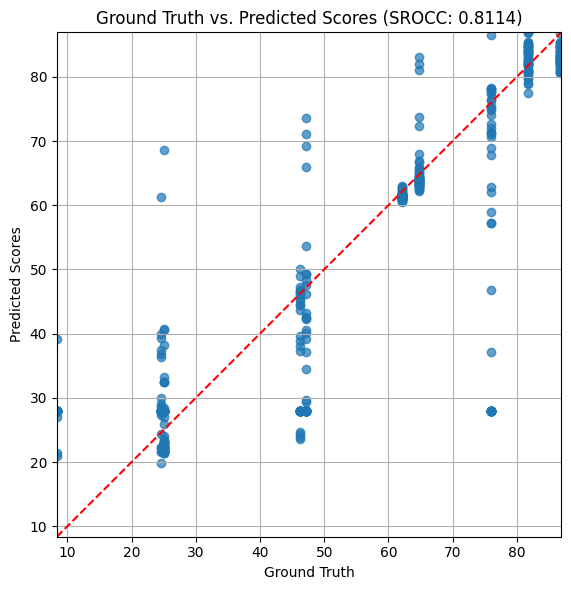

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Assuming you have ground truth values in 'target_arr' and predicted values in 'pred'

# Calculate SROCC
srocc, _ = stats.spearmanr(target_arr, pred)

# Determine plot limits for equal ranges and scale
min_val = min(min(target_arr), min(pred))
max_val = max(max(target_arr), max(pred))
plot_range = (min_val, max_val)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(target_arr, pred, alpha=0.7)

# Set title and labels with SROCC value
plt.title(f"Ground Truth vs. Predicted Scores (SROCC: {srocc:.4f})")
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Scores")

# Set x and y limits to the same range
plt.xlim(plot_range)
plt.ylim(plot_range)

# Ensure equal aspect ratio for same scale
plt.gca().set_aspect('equal', adjustable='box')

# Draw diagonal line
plt.plot(plot_range, plot_range, color='red', linestyle='--')

# Customize plot appearance (optional)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [55]:
# prompt: give code for generating mse also

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #Import the necessary functions

# Testing step (modified to include additional metrics)
model.eval()
test_loss = 0.0
target_arr = []
pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        pred.extend(outputs.squeeze().cpu().numpy())
        target_arr.extend(targets.cpu().numpy())
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Calculate MSE
mse = mean_squared_error(target_arr, pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Calculate additional metrics
mae = mean_absolute_error(target_arr, pred)
rmse = np.sqrt(mean_squared_error(target_arr, pred))
r2 = r2_score(target_arr, pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Test Loss: 184.6725
Mean Squared Error (MSE): 192.9809
Mean Absolute Error (MAE): 8.5325
Root Mean Squared Error (RMSE): 13.8918
R-squared (R2): 0.6989
